In [1]:


import yaml, torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from sklearn.manifold import TSNE

from tqdm import tqdm

from types import SimpleNamespace
import os, sys


In [2]:

project_dir = '/home/alcindo/projeto/hsi-msn/msn'
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)
os.chdir(project_dir)


In [3]:
config_path = os.path.join(project_dir, 'output','proto20_embed256' ,'config.yaml')

with open(config_path, 'r') as f:
        config_dict = yaml.safe_load(f)
        config = SimpleNamespace(**config_dict)

In [4]:
config

namespace(alpha_ema=0.996,
          attn_drop_rate=0.0,
          batch_size=16,
          data_root='./../hsi_airborne/data.npy',
          depth=4,
          drop_path_rate=0.0,
          drop_rate=0.0,
          embed_dim=256,
          epoch_stop_prototype=5,
          final_lr=1e-06,
          final_weight_decay=0.05,
          focal_crop_scale=[0.5, 0.6],
          focal_size=[12, 12, 430],
          focal_views=1,
          in_chans=1,
          lambda_reg=0.01,
          learning_rate=0.0001,
          mask_ratio=0.75,
          mlp_ratio=4.0,
          num_epochs=100,
          num_heads=8,
          num_prototipos=20,
          num_workers=1,
          output_dir='./output/proto20_embed256',
          patch_size=[2, 2, 10],
          pin_memory=True,
          project_name='hsi-msn',
          rand_crop_scale=[0.9, 1.0],
          rand_size=[20, 20, 430],
          rand_views=2,
          resume_from=None,
          save_freq_epochs=50,
          spectral_jitter_strength=0.1

## Load dataset

In [5]:
from src.dataset import init_data
from torch.utils.data import DataLoader

dataset = init_data(config_dict)


0it [00:00, ?it/s]

(16, 1, 430, 20, 20)


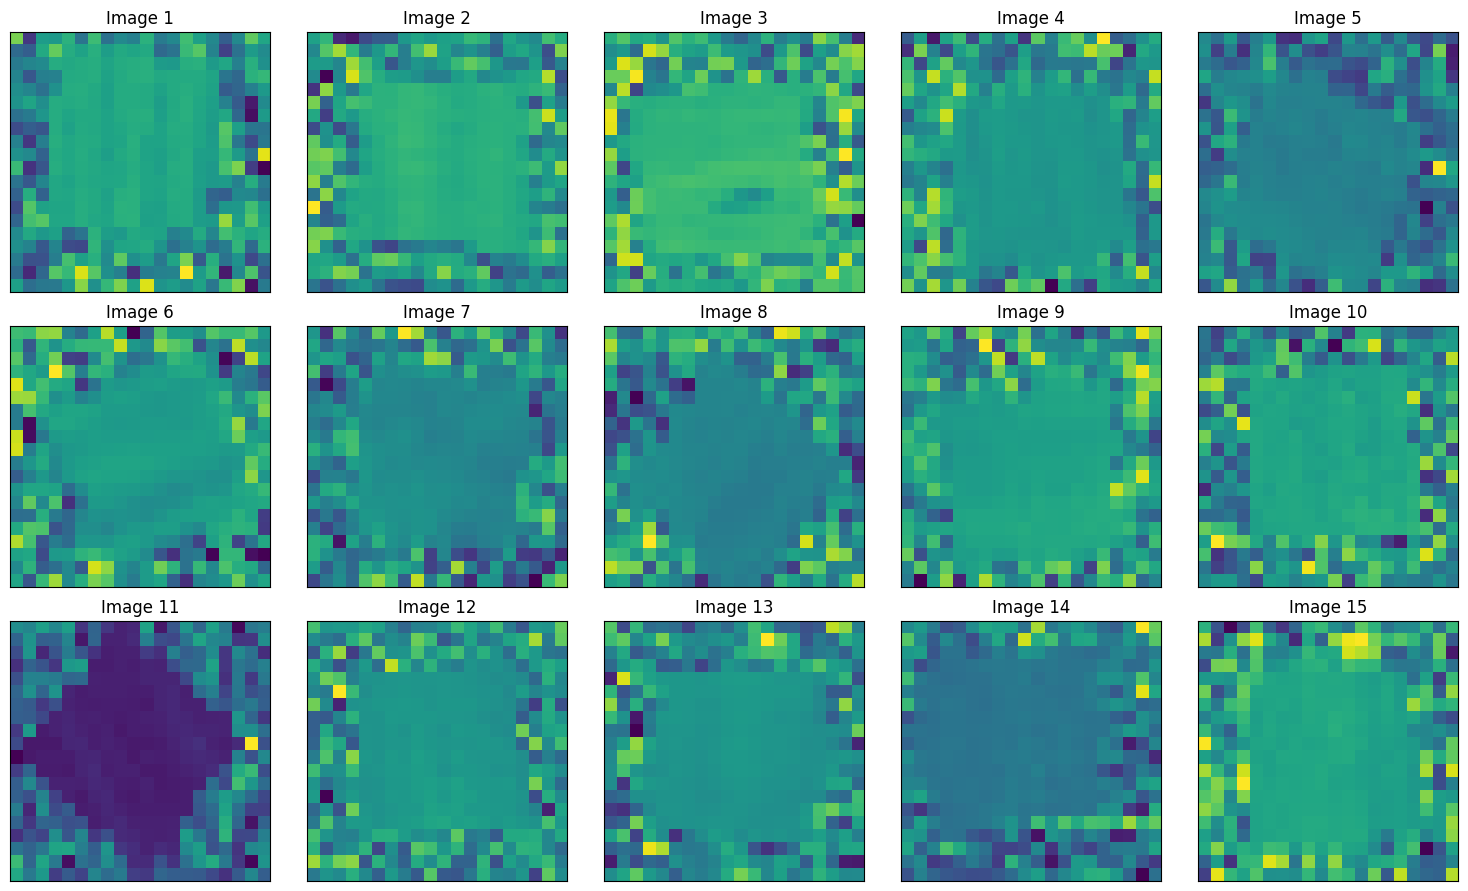

0it [00:00, ?it/s]


In [6]:
# the dataloader returns prisma_data, sentinel_data, airborne_data, 0

# plot 15 images from  airborne data  5x3 grid

#  withe theme

plt.style.use('default')


BAND_NUMBER = 10

for i, views in tqdm(enumerate(dataset)):
    views = [v for v in views]

     # shape [32, 1, 430, 20, 20] view[0] plot
     # view[0] to numpy

    view = views[0].detach().cpu().numpy()

    #plot
    print(view.shape)

    fig, axs = plt.subplots(3, 5, figsize=(15, 9))
    axs = axs.flatten()
    for j in range(15):
        axs[j].imshow(view[j,0, BAND_NUMBER, :, :])
        axs[j].set_title(f'Image {j+1}')
        axs[j].set_xticks([])
        axs[j].set_yticks([])
    plt.tight_layout()
    plt.show()

    break

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#device = "cpu"
from src.hsi_msn import MSNModel

model = MSNModel(config).to(device)


checkpoint_path = f"{config.output_dir}/min_loss_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])



ModuleList(
  (0-3): 4 x Block(
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (attn): Attention(
      (q): Linear(in_features=256, out_features=256, bias=True)
      (k): Linear(in_features=256, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=256, bias=True)
      (proj): Linear(in_features=256, out_features=256, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (drop_path): Identity()
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (mlp): SwiGLU(
      (w1): Linear(in_features=256, out_features=684, bias=True)
      (w2): Linear(in_features=684, out_features=256, bias=True)
      (w3): Linear(in_features=256, out_features=684, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
)
rand_pos_embed torch.Size([1, 4300, 256])


<All keys matched successfully>

In [9]:
checkpoint["epoch"]

1

In [10]:
prot = model.prototypes
prot = prot.to(device)
prot = torch.nn.functional.normalize(prot, dim = 0 )
prot.shape

torch.Size([20, 256])

In [11]:
model.eval()

E = torch.empty(0, config.embed_dim).to(device)
F = torch.empty(0, prot.shape[0]).to(device)



with torch.no_grad():

    for i , views in tqdm(enumerate(dataset)):

        views = views[0].to(device)
        z_views = model.target_encoder(views)

        z_views = torch.nn.functional.normalize(z_views, dim=1)

        E = torch.cat((E, z_views), 0)

        F = torch.cat((F, z_views @ prot.T), 0)


117it [00:23,  5.06it/s]


In [12]:
# Concatenate prototypes and latent points
data = torch.cat((E.cpu(), prot.cpu()), dim=0).detach().numpy()

# Apply TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(data)

# Separate the results for prototypes and latent points
tsne_E = tsne_results[:E.shape[0]]
tsne_prot = tsne_results[E.shape[0]:]


In [13]:
# value count clsuter labels

cluster_labels = torch.argmax(F, dim=1).cpu().numpy()     
cluster_labels = pd.Series(cluster_labels)
cluster_counts = cluster_labels.value_counts().sort_index()
print(cluster_counts) 

15    1872
Name: count, dtype: int64


In [14]:
# read train_gt.csv

train_gt_path = os.path.join( './../train_gt.csv')
train_gt = pd.read_csv(train_gt_path)


train_gt = train_gt[0:len(E)]

In [15]:
train_gt

,sample_index,B,Cu,Zn,Fe,S,Mn
0,0,0.8,2.1,5.0,186.6,12.078640,110.7
1,1,0.6,3.5,7.3,255.6,12.199673,75.7
2,2,0.5,2.1,2.3,204.0,65.882013,87.1
3,3,0.8,1.9,3.3,165.6,31.942712,56.0
4,4,0.5,2.4,5.8,419.9,35.970698,65.1
...,...,...,...,...,...,...,...
1867,1867,0.5,2.1,7.0,239.8,12.790768,74.6
1868,1868,0.8,1.9,1.9,230.8,24.179018,67.3
1869,1869,0.7,2.9,2.3,200.2,33.473814,104.9
1870,1870,1.1,3.3,8.0,275.1,36.132456,113.8


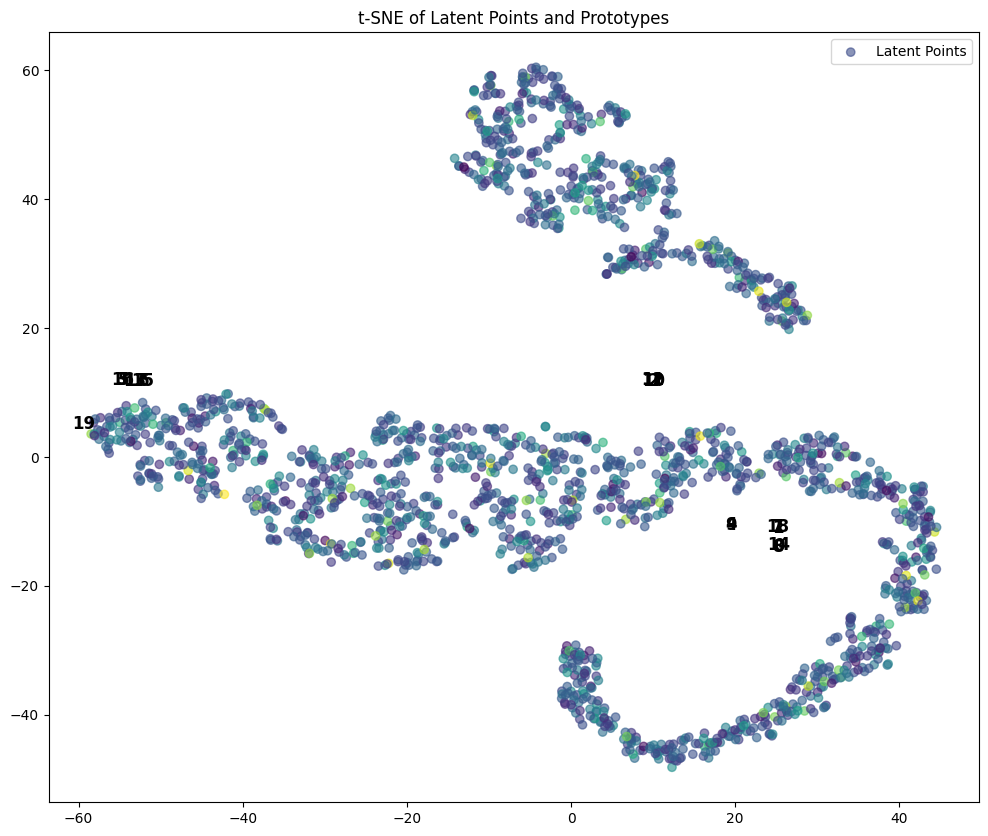

In [16]:

elemento = 'Fe'


# Plotar os resultados do t-SNE
cluster_labels = train_gt[elemento]
plt.figure(figsize=(12, 10))

# Use 'c' para o mapeamento de cores e guarde o objeto do scatter plot
scatter = plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c=cluster_labels, cmap='viridis', label='Latent Points', alpha=0.6)

# # Adiciona a barra de cores and title
# cbar = plt.colorbar(scatter)
# cbar.set_label(elemento, rotation=270, labelpad=15) # Adiciona um rótulo à barra de cores



# Adiciona os protótipos ao gráfico
for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center', weight='bold')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes")

# title colorbar label

# Salva a figura em um arquivo
plt.savefig('tsne_plot.png')


TypeError: 'DataLoader' object is not subscriptable

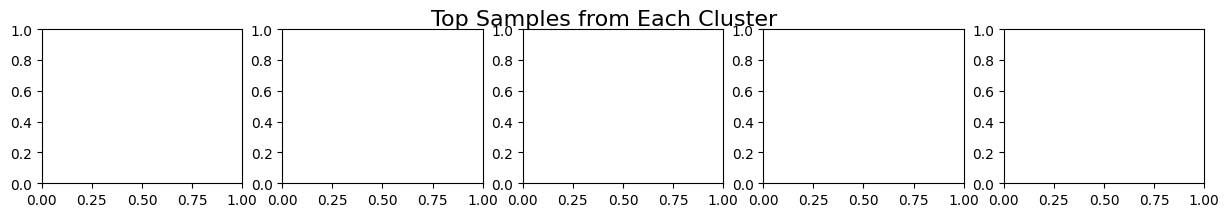

In [17]:

Top = 5
BAND_NUMBER = 10

max_val, max_idx = torch.max(F, dim=1)  # Obtém os valores máximos e seus índices
df = pd.DataFrame({"max_idx": max_idx.cpu(), "max_val": max_val.cpu()})

# Filtra apenas os clusters que possuem amostras
clusters_with_samples = sorted(df["max_idx"].unique().tolist())
n_clusters = len(clusters_with_samples)

# Ajusta o grid para mostrar apenas 'Top' imagens por cluster
fig, axes = plt.subplots(n_clusters, Top, figsize=(Top * 3, n_clusters * 2))

# Garante que 'axes' seja sempre 2D para consistência, mesmo com um único cluster
if n_clusters == 1:
    axes = np.expand_dims(axes, 0)

fig.suptitle("Top Samples from Each Cluster", fontsize=16)

for row, i in enumerate(clusters_with_samples):
    top_samples = df[df["max_idx"] == i].nlargest(Top, "max_val")

    for j, im_index in enumerate(top_samples.index):
        image_data = dataset[im_index][2].numpy()

        # Seleciona o subplot correto
        ax = axes[row, j]

        # Plota a imagem da banda especificada sem vmin/vmax fixos
        ax.imshow(image_data[BAND_NUMBER, :, :], cmap='coolwarm',vmin=-7.0872, vmax=4.1556)
        ax.axis("off")

    # Adiciona o título do cluster na lateral da linha
    axes[row, 0].text(-0.5, 0.5, f"Cluster {i}", transform=axes[row, 0].transAxes,
                      fontsize=12, va='center', ha='right', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
model.eval()

E = torch.empty(0, config.tamanho_embedding).to(device)
F = torch.empty(0, prot.shape[0]).to(device)


with torch.no_grad():

    for i, (prisma_data, sentinel_data, airborne_data, _) in tqdm(enumerate(dataset)):

        airborne_data = airborne_data.to(device)
        airborne_data = airborne_data.unsqueeze(0)
        emb_airbone_hyper = model.make_embedding_airbone_hyper(airborne_data)
        z_airbone_hyper_target = model.target_encoder(emb_airbone_hyper)

        z_airbone_hyper_target = torch.nn.functional.normalize(z_airbone_hyper_target, dim=1)

        E = torch.cat((E, z_airbone_hyper_target), 0)

        F = torch.cat((F, z_airbone_hyper_target @ prot.T), 0)

1876it [00:01, 1613.01it/s]


In [ ]:

E = torch.empty(0, config.tamanho_embedding).to(device)
F = torch.empty(0, prot.shape[0]).to(device)


with torch.no_grad():

    for i, (prisma_data, sentinel_data, airborne_data, _) in tqdm(enumerate(dataset)):

        sentinel_data = sentinel_data.to(device)
        sentinel_data = sentinel_data.unsqueeze(0)
        emb_sentinel = model.make_embedding_sentinel2(sentinel_data)
        #  z_sentinel_target = model.target_encoder(emb_sentinel)
        #  z_sentinel_target = torch.nn.functional.normalize(z_sentinel_target, dim=1)
        # E = torch.cat((E, z_sentinel_target), 0)
        # F = torch.cat((F, z_sentinel_target @ prot.T), 0)

        prisma_data = prisma_data.to(device)
        prisma_data = prisma_data.unsqueeze(0)
        emb_prisma = model.make_embedding_prisma(prisma_data)

        # concatena os embeddings de Prisma e Sentinel2
        # para que o encoder estudante possa processar ambos simultaneamente
        emb_student = torch.cat((emb_prisma, emb_sentinel), dim=1)

        z_prisma_target = model.student_encoder(emb_student)
        z_prisma_target = torch.nn.functional.normalize(z_prisma_target, dim=1)
        E = torch.cat((E, z_prisma_target), 0)
        F = torch.cat((F, z_prisma_target @ prot.T), 0)



1876it [00:01, 1600.19it/s]


In [ ]:
# Concatenate prototypes and latent points
data = torch.cat((E.cpu(), prot.cpu()), dim=0).detach().numpy()

# Apply TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(data)

# Separate the results for prototypes and latent points
tsne_E = tsne_results[:E.shape[0]]
tsne_prot = tsne_results[E.shape[0]:]

Text(0.5, 1.0, 't-SNE of Latent Points and Prototypes - Prisma')

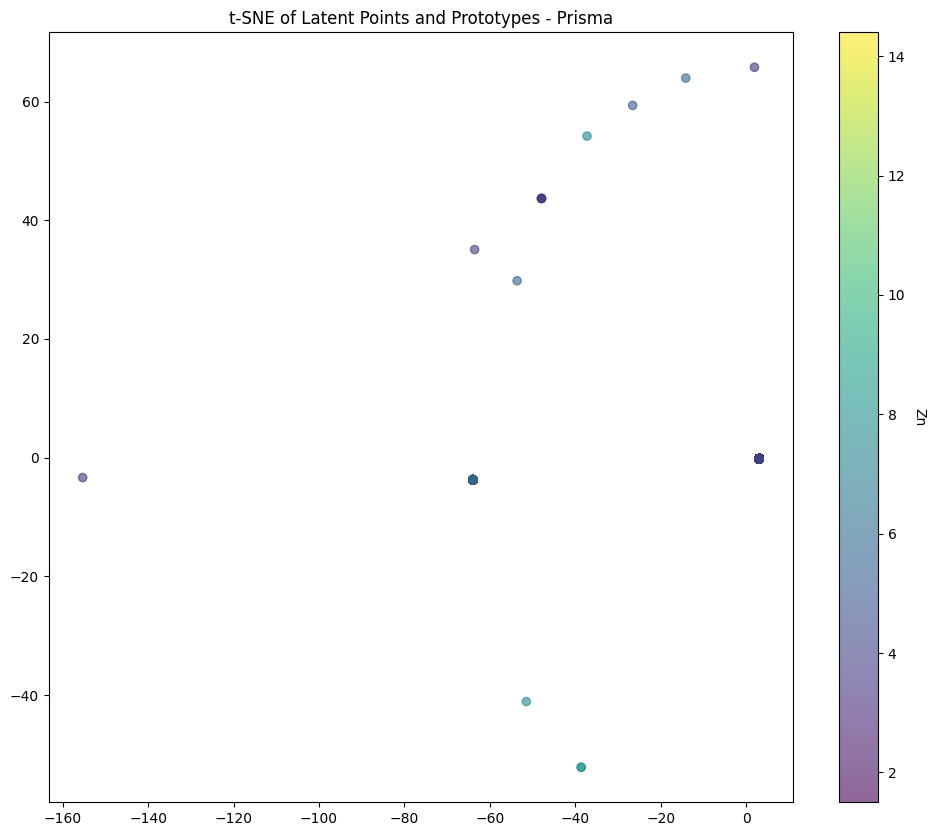

In [ ]:

elemento = 'Zn'


# Plotar os resultados do t-SNE
cluster_labels = train_gt[elemento]
plt.figure(figsize=(12, 10))

scatter = plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c=cluster_labels, cmap='viridis', label='Latent Points', alpha=0.6)

# Adiciona a barra de cores and title
cbar = plt.colorbar(scatter)
cbar.set_label(elemento, rotation=270, labelpad=15)  # Adiciona um rótulo à barra de cores

# title

plt.title("t-SNE of Latent Points and Prototypes - Prisma")

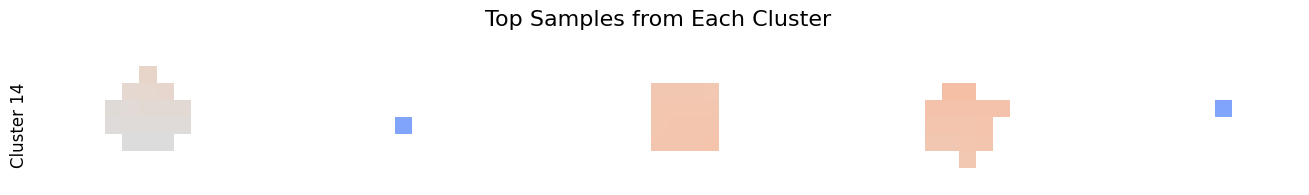

In [ ]:

Top = 5
BAND_NUMBER = 10

max_val, max_idx = torch.max(F, dim=1)  # Obtém os valores máximos e seus índices
df = pd.DataFrame({"max_idx": max_idx.cpu(), "max_val": max_val.cpu()})

# Filtra apenas os clusters que possuem amostras
clusters_with_samples = sorted(df["max_idx"].unique().tolist())
n_clusters = len(clusters_with_samples)

# Ajusta o grid para mostrar apenas 'Top' imagens por cluster
fig, axes = plt.subplots(n_clusters, Top, figsize=(Top * 3, n_clusters * 2))

# Garante que 'axes' seja sempre 2D para consistência, mesmo com um único cluster
if n_clusters == 1:
    axes = np.expand_dims(axes, 0)

fig.suptitle("Top Samples from Each Cluster", fontsize=16)

for row, i in enumerate(clusters_with_samples):
    top_samples = df[df["max_idx"] == i].nlargest(Top, "max_val")
    for j, im_index in enumerate(top_samples.index):
        image_data = dataset[im_index][1].numpy()

        # Seleciona o subplot correto
        ax = axes[row, j]
        
        # Plota a imagem da banda especificada sem vmin/vmax fixos
        ax.imshow(image_data[BAND_NUMBER, :, :], cmap='coolwarm',vmin=-7.0872, vmax=4.1556)
        ax.axis("off")
        
    # Adiciona o título do cluster na lateral da linha
    axes[row, 0].text(-0.5, 0.5, f"Cluster {i}", transform=axes[row, 0].transAxes,
                      fontsize=12, va='center', ha='right', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:

pd.DataFrame(E.cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.013602,0.15563,0.054603,0.006261,-0.102352,0.136322,0.014897,0.05059,-0.059217,0.006091,...,-0.003414,-0.275364,0.086818,-0.083766,-0.03002,-0.023327,-0.011402,0.087757,-0.0371,0.141766
1,-0.013602,0.15563,0.054603,0.006261,-0.102352,0.136322,0.014897,0.05059,-0.059217,0.006091,...,-0.003414,-0.275364,0.086818,-0.083766,-0.03002,-0.023327,-0.011402,0.087757,-0.0371,0.141766
2,-0.013602,0.15563,0.054603,0.006261,-0.102352,0.136322,0.014897,0.05059,-0.059217,0.006091,...,-0.003414,-0.275364,0.086818,-0.083766,-0.03002,-0.023327,-0.011402,0.087757,-0.0371,0.141766
3,-0.013602,0.15563,0.054603,0.006261,-0.102352,0.136322,0.014897,0.05059,-0.059217,0.006091,...,-0.003414,-0.275364,0.086818,-0.083766,-0.03002,-0.023327,-0.011402,0.087757,-0.0371,0.141766
4,-0.013602,0.15563,0.054603,0.006261,-0.102352,0.136322,0.014897,0.05059,-0.059217,0.006091,...,-0.003414,-0.275364,0.086818,-0.083766,-0.03002,-0.023327,-0.011402,0.087757,-0.0371,0.141766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1871,-0.013602,0.15563,0.054603,0.006261,-0.102352,0.136322,0.014897,0.05059,-0.059217,0.006091,...,-0.003414,-0.275364,0.086818,-0.083766,-0.03002,-0.023327,-0.011402,0.087757,-0.0371,0.141766
1872,-0.013602,0.15563,0.054603,0.006261,-0.102352,0.136322,0.014897,0.05059,-0.059217,0.006091,...,-0.003414,-0.275364,0.086818,-0.083766,-0.03002,-0.023327,-0.011402,0.087757,-0.0371,0.141766
1873,-0.013602,0.15563,0.054603,0.006261,-0.102352,0.136322,0.014897,0.05059,-0.059217,0.006091,...,-0.003414,-0.275364,0.086818,-0.083766,-0.03002,-0.023327,-0.011402,0.087757,-0.0371,0.141766
1874,-0.013602,0.15563,0.054603,0.006261,-0.102352,0.136322,0.014897,0.05059,-0.059217,0.006091,...,-0.003414,-0.275364,0.086818,-0.083766,-0.03002,-0.023327,-0.011402,0.087757,-0.0371,0.141766
